# Simple Waveform Synthesizer

This notebook helps to generate a sample waveform to experiment on haptic motors.

---
## Implementation


In [117]:
import math
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import wave
import pyaudio

In [118]:
# Parameters
# ---------

# Sampling frequency
sample_rate = 44100

# bit depth
bit_depth = 16


In [119]:
class Synth:
    def __init__(self, sample_rate = 44100, bit_depth = 16):
        self.sample_rate = sample_rate
        self.bit_depth = bit_depth
        self.audio = np.zeros(0)
        self.__max_amplitude = 2 ** (self.bit_depth - 1) - 1

    def __calculate_duration(self):
        # Calculate the duration of the audio in milliseconds
        return len(self.audio) / self.sample_rate * 1000
    
    def append(self, other: 'Synth'):
        # Append another audio signal
        if self.sample_rate != other.sample_rate:
            raise ValueError("Sample rates do not match")
        if self.bit_depth != other.bit_depth:
            raise ValueError("Bit depths do not match")
        
        self.audio = np.append(self.audio, other.audio)

        return self
    
    def __add__(self, other: 'Synth'):
        # Add two audio signals
        if self.sample_rate != other.sample_rate:
            raise ValueError("Sample rates do not match")
        if self.bit_depth != other.bit_depth:
            raise ValueError("Bit depths do not match")
        
        
        max_len = max(len(self.audio), len(other.audio))
        self_audio = np.pad(self.audio, (0, max_len - len(self.audio)), 'constant')
        other_audio = np.pad(other.audio, (0, max_len - len(other.audio)), 'constant')
        new_audio = np.clip(self_audio + other_audio, -self.__max_amplitude, self.__max_amplitude)
        result = Synth(self.sample_rate, self.bit_depth)
        result.audio = new_audio
        return result
    
    def __sub__(self, other: 'Synth'):
        # Subtract two audio signals
        if self.sample_rate != other.sample_rate:
            raise ValueError("Sample rates do not match")
        if self.bit_depth != other.bit_depth:
            raise ValueError("Bit depths do not match")
        
        max_len = max(len(self.audio), len(other.audio))
        self_audio = np.pad(self.audio, (0, max_len - len(self.audio)), 'constant')
        other_audio = np.pad(other.audio, (0, max_len - len(other.audio)), 'constant')
        new_audio = np.clip(self_audio - other_audio, -self.__max_amplitude, self.__max_amplitude)
        result = Synth(self.sample_rate, self.bit_depth)
        result.audio = new_audio
        return result
    
    def __mul__(self, other: 'Synth'):
        # Multiply two audio signals
        if self.sample_rate != other.sample_rate:
            raise ValueError("Sample rates do not match")
        if self.bit_depth != other.bit_depth:
            raise ValueError("Bit depths do not match")
        
        max_len = max(len(self.audio), len(other.audio))
        self_audio = np.pad(self.audio, (0, max_len - len(self.audio)), 'constant')
        other_audio = np.pad(other.audio, (0, max_len - len(other.audio)), 'constant')
        new_audio = np.clip(self_audio * other_audio // self.__max_amplitude, -self.__max_amplitude, self.__max_amplitude)
        result = Synth(self.sample_rate, self.bit_depth)
        result.audio = new_audio
        return result

    def silence(self, duration=100):
        # Add silence to the audio
        samples = int(self.sample_rate * duration / 1000)
        audio = np.append(self.audio, np.zeros(samples))
        synth = Synth(self.sample_rate, self.bit_depth)
        synth.audio = audio

        return synth
    
    def monotone(self, frequency=440, duration=100, amplitude: float=1):
        # Add a monotone to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.ones(samples)

        synth = Synth(self.sample_rate, self.bit_depth)
        synth.audio = audio

        return synth

    def sine_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Add a sine wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.sin(2 * np.pi * frequency * t)
        
        synth = Synth(self.sample_rate, self.bit_depth)
        synth.audio = audio

        return synth
    
    def square_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Add a square wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.sign(np.sin(2 * np.pi * frequency * t))
        
        synth = Synth(self.sample_rate, self.bit_depth)
        synth.audio = audio

        return synth
    
    def triangle_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Add a triangle wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.arcsin(np.sin(2 * np.pi * frequency * t))
        
        synth = Synth(self.sample_rate, self.bit_depth)
        synth.audio = audio

        return synth
    
    def sawtooth_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Add a sawtooth wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * 2 * (t * frequency - np.floor(t * frequency + 0.5))
        
        synth = Synth(self.sample_rate, self.bit_depth)
        synth.audio = audio

        return synth
    
    def append_silence(self, duration=100):
        # Append silence to the audio
        samples = int(self.sample_rate * duration / 1000)
        self.audio = np.append(self.audio, np.zeros(samples))

        return self
    
    def append_monotone(self, frequency=440, duration=100, amplitude: float=1):
        # Append a monotone to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.ones(samples)

        self.audio = np.append(self.audio, audio)

        return self
    
    def append_sine_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Append a sine wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.sin(2 * np.pi * frequency * t)

        self.audio = np.append(self.audio, audio)

        return self
    
    def append_square_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Append a square wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.sign(np.sin(2 * np.pi * frequency * t))

        self.audio = np.append(self.audio, audio)

        return self
    
    def append_triangle_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Append a triangle wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * np.arcsin(np.sin(2 * np.pi * frequency * t))

        self.audio = np.append(self.audio, audio)

        return self
    
    def append_sawtooth_wave(self, frequency=440, duration=100, amplitude: float=1):
        # Append a sawtooth wave to the audio
        samples = int(self.sample_rate * duration / 1000)
        t = np.linspace(0, duration, samples)
        audio = amplitude * self.__max_amplitude * 2 * (t * frequency - np.floor(t * frequency + 0.5))

        self.audio = np.append(self.audio, audio)

        return self

    def save_wav(self, filename):
        # Save the audio to a .wav file
        wav_file = wave.open(filename, "w")
        wav_file.setnchannels(1)
        wav_file.setsampwidth(self.bit_depth // 8)
        wav_file.setframerate(self.sample_rate)
        wav_file.writeframes(self.audio.tobytes())
        wav_file.close()

    def play(self):
        # Play the audio
        p = pyaudio.PyAudio()
        stream = p.open(format=p.get_format_from_width(self.bit_depth // 8),
                        channels=1,
                        rate=self.sample_rate,
                        output=True)
        stream.write(self.audio.tobytes())
        stream.stop_stream()
        stream.close()
        p.terminate()

    def plot(self, title="Waveform", preview=False):
        # Plot the audio
        plt.figure(figsize=(20, 5))
        duration: int = int(self.__calculate_duration())
        plt.title(title)
        plt.plot(self.audio)
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()


---
##  Playground

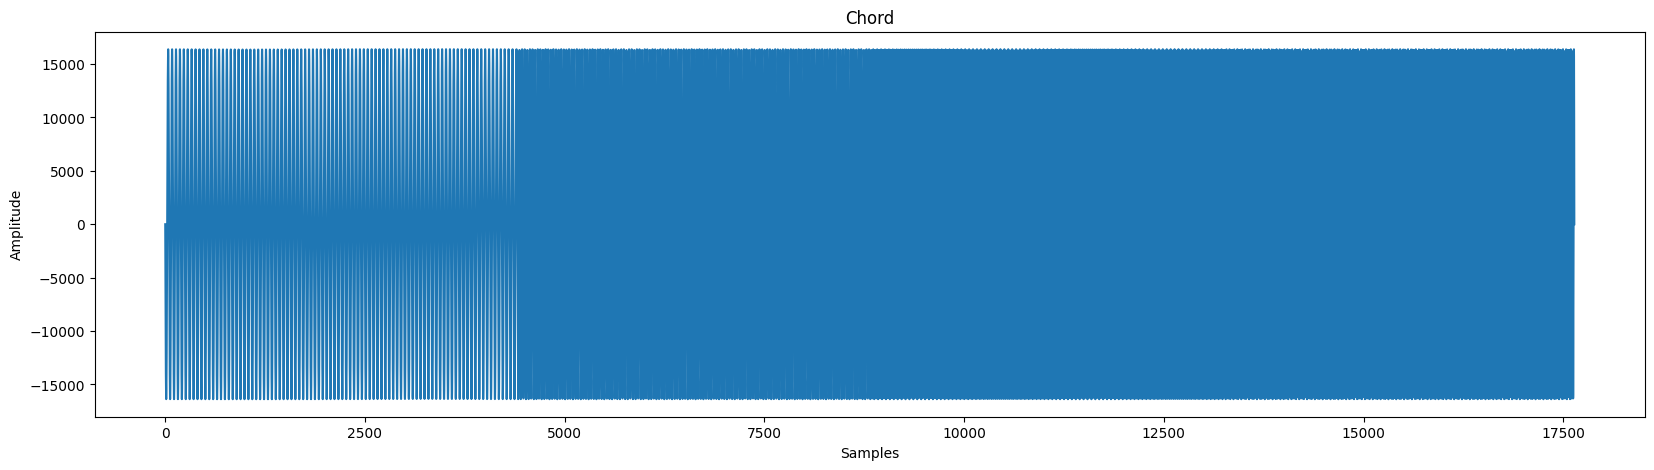

In [124]:
audio = Synth(sample_rate, bit_depth)

# Usage Pattern 1: Using the append method
audio.append_sine_wave(440, 100, 0.5)
audio.append_sine_wave(660, 100, 0.5)
audio.append_sine_wave(880, 100, 0.5)
audio.append_sine_wave(1100, 100, 0.5)

audio.plot("Chord")


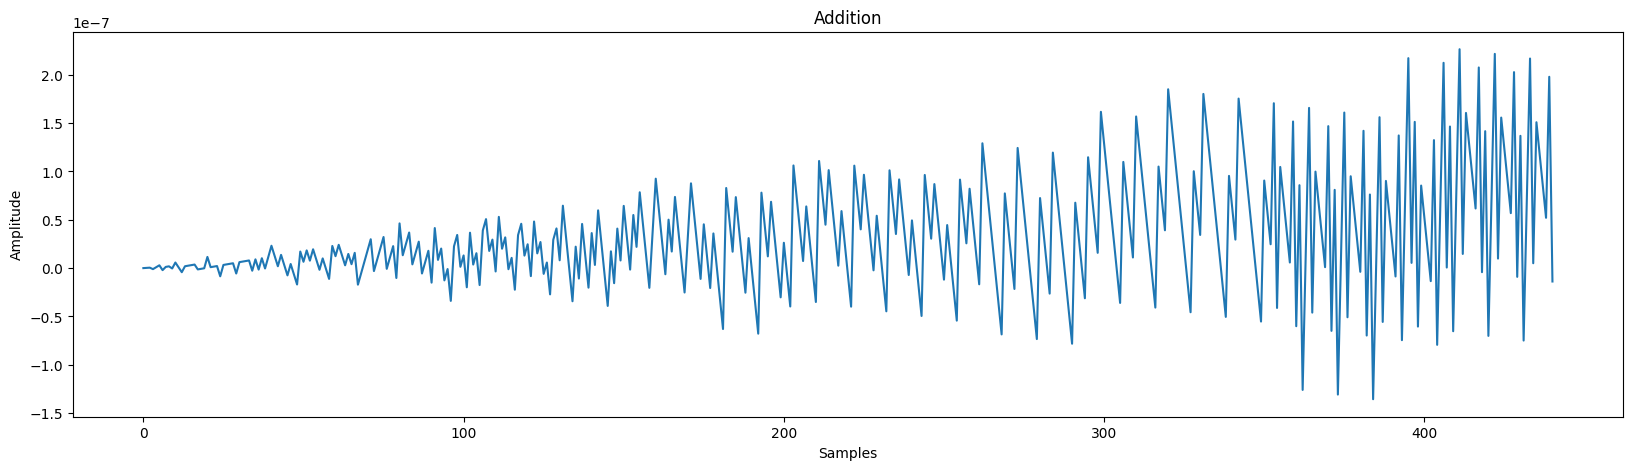

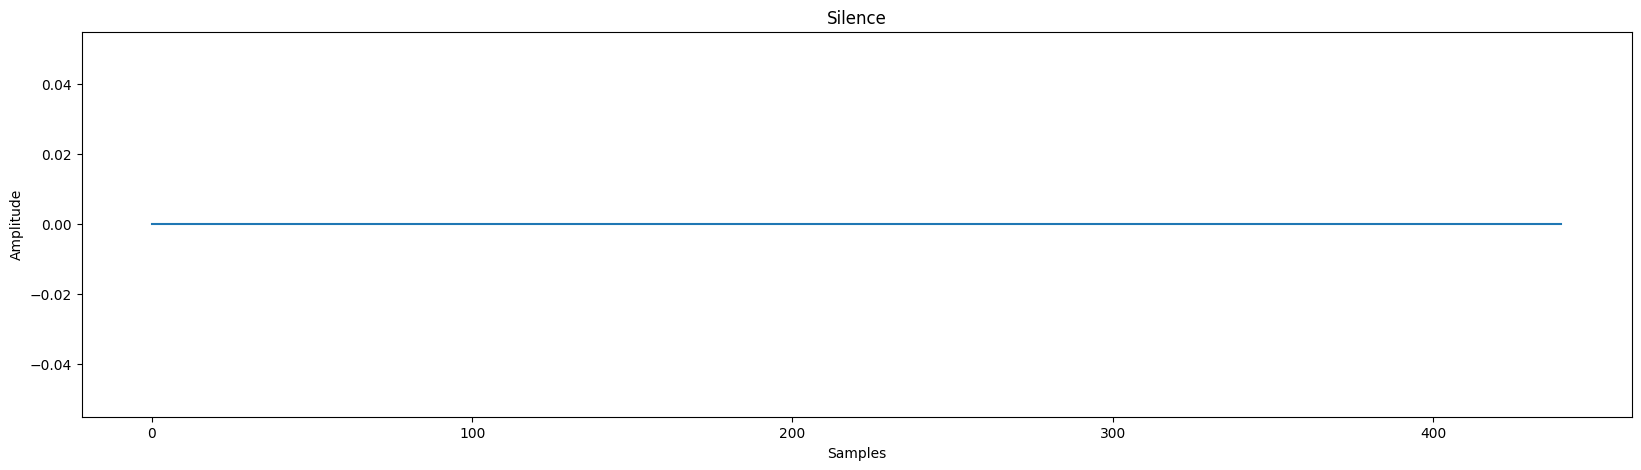

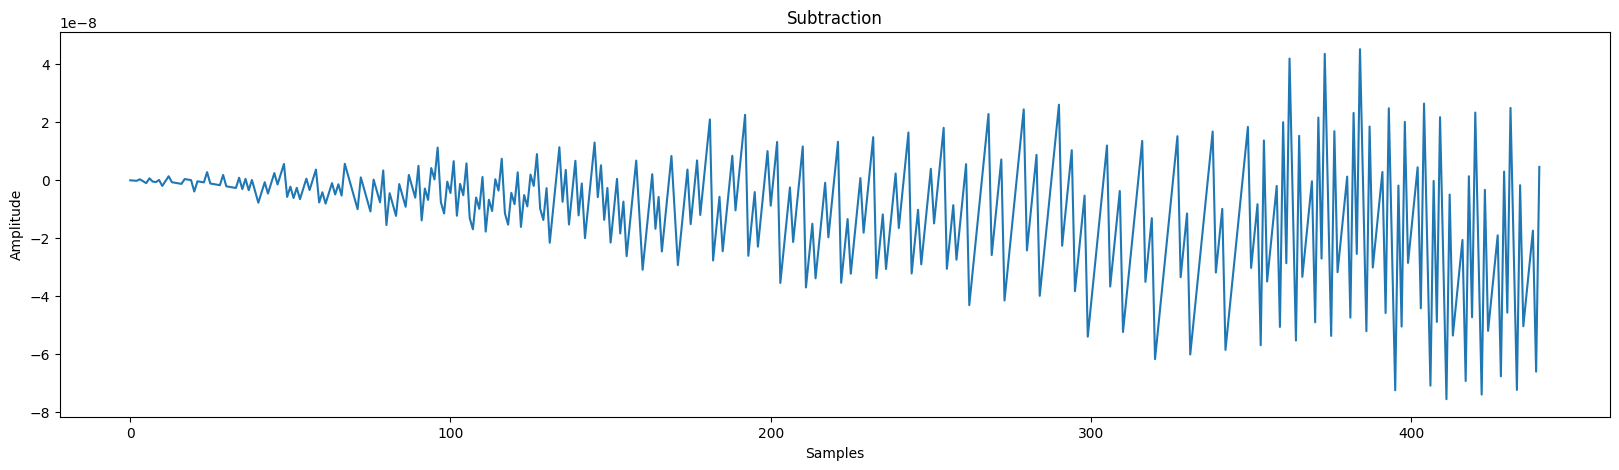

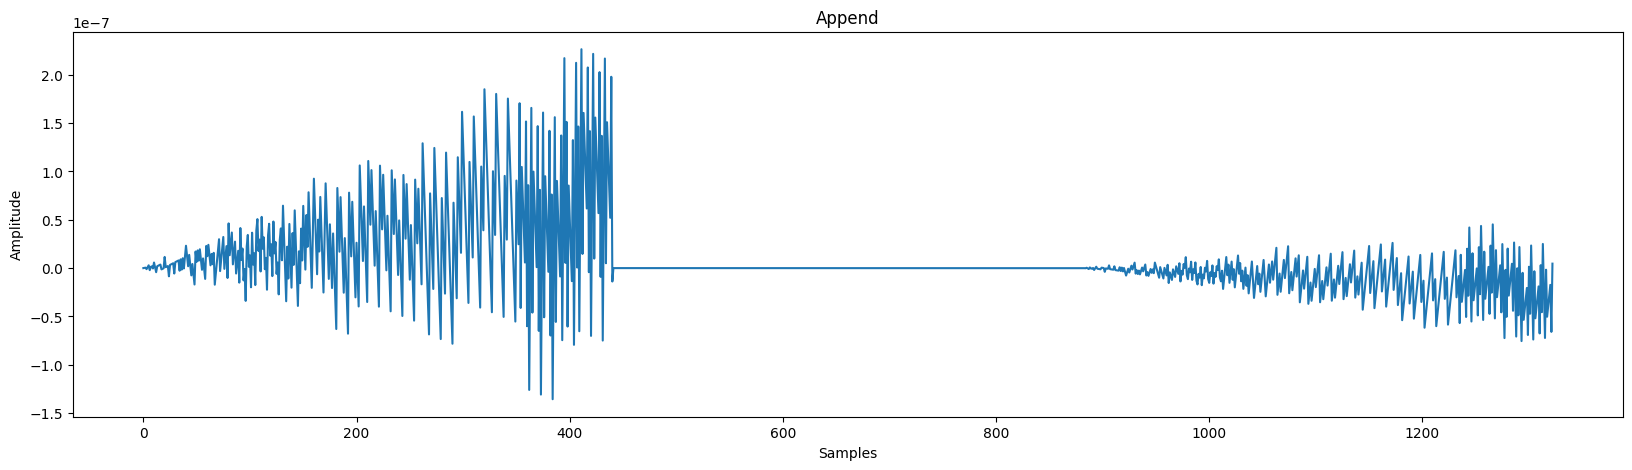

In [121]:
audio = Synth(sample_rate, bit_depth)

# Usage Pattern 2: Using the operator (like we actually do in Signal Processing)
audio1 = audio.sine_wave(440, 10, 0.5) + audio.sine_wave(880, 10, 0.5)
audio1.plot("Addition")

audio2 = Synth.silence(audio, 10)
audio2.plot("Silence")

audio3 = audio.sine_wave(440, 10, 0.5) - audio.sine_wave(880, 10, 0.5)
audio3.plot("Subtraction")

audio1.append(audio2).append(audio3)

audio1.plot("Append")

